## Семинар 9
# Тема: Многомерные методы импутации пропусков

#### Многомерные способы импутации пропущенных значений

Многомерные способы импутации пропусков - это замещение пропусков в каждом признаке, используя данные из других признаков тоже, а не только того признака, в котором осуществляется импутация. Другими словами, мы строим модель машинного обучения для заполнения пропусков.Такой моделью может быть линейная регрессия для количественных признаков или логистическая регрессия для категориальных. Обратите внимание, что хотя технически мы могли бы использовать исходную целевую переменную в качестве одного из признаков для заполнения пропусков, делать этого не стоит, потому что в этом случае мы создадим между ними взаимосвязь, которой изначально могло не быть.

Импортируем необходимые библиотеки:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

from sklearn.impute import KNNImputer

### 1. Загрузите датасет `Titanic.csv`. Выведите размеры загруженного датафрейма и информацию о данных.

In [4]:
df = pd.read_csv("/content/Titanic-3.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df.shape

(891, 12)

### 2. Удалите из загруженного датафрейма целевую переменную Survived.

In [7]:
df_features = df.drop('Survived', axis=1)
df_features.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 3. Замените значения в признаке 'Sex' в соответствии со словарём {'male': 1, 'female': 0}. Оставьте в датафрейме только числовые признаки и выведите первые 3 строки.

In [8]:
df_features['Sex'] = df_features['Sex'].map({'male': 1, 'female': 0})
df_features.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


In [9]:
df_features = df.select_dtypes(exclude=['object'])
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Age          714 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


### 4. Убедитесь, что единственный признак, в котором есть пропуски - это Age.

In [10]:
df_features.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Age,177
SibSp,0
Parch,0
Fare,0


### 5. Произведите масштабирование данных, выполнив стандартную нормализацию. Представьте результат в виде датафрейма  df_scaled, добавив названия колонок.

In [11]:
scaler = StandardScaler()
scaler_data = scaler.fit_transform(df_features)
scaler_data

array([[-1.73010796, -0.78927234,  0.82737724, ...,  0.43279337,
        -0.47367361, -0.50244517],
       [-1.72622007,  1.2669898 , -1.56610693, ...,  0.43279337,
        -0.47367361,  0.78684529],
       [-1.72233219,  1.2669898 ,  0.82737724, ..., -0.4745452 ,
        -0.47367361, -0.48885426],
       ...,
       [ 1.72233219, -0.78927234,  0.82737724, ...,  0.43279337,
         2.00893337, -0.17626324],
       [ 1.72622007,  1.2669898 , -1.56610693, ..., -0.4745452 ,
        -0.47367361, -0.04438104],
       [ 1.73010796, -0.78927234,  0.82737724, ..., -0.4745452 ,
        -0.47367361, -0.49237783]])

In [12]:
df_scaled = pd.DataFrame(scaler_data, columns = df_features.columns)
df_scaled.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,-1.730108,-0.789272,0.827377,-0.530377,0.432793,-0.473674,-0.502445
1,-1.726220,1.266990,-1.566107,0.571831,0.432793,-0.473674,0.786845
2,-1.722332,1.266990,0.827377,-0.254825,-0.474545,-0.473674,-0.488854
3,-1.718444,1.266990,-1.566107,0.365167,0.432793,-0.473674,0.420730
4,-1.714556,-0.789272,0.827377,0.365167,-0.474545,-0.473674,-0.486337


### 6. Из этого датафрейма выделите датафрейм, состоящий из строк, в которых в столбце Age стоят пропуски, создайте его копию и обозначьте её за Test. Удалите из датафрейма Test столбец Age и обозначьте полученный датафрейм X_test.

In [13]:
df_scaled[df_scaled['Age'].isna()].head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
5,-1.710669,-0.789272,0.827377,NaN,-0.474545,-0.473674,-0.478116
17,-1.664014,1.266990,-0.369365,NaN,-0.474545,-0.473674,-0.386671
19,-1.656238,1.266990,0.827377,NaN,-0.474545,-0.473674,-0.502949
26,-1.629023,-0.789272,0.827377,NaN,-0.474545,-0.473674,-0.502949
28,-1.621247,1.266990,0.827377,NaN,-0.474545,-0.473674,-0.489776


In [14]:
Test = df_scaled[df_scaled['Age'].isna()].copy()
Test.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
5,-1.710669,-0.789272,0.827377,NaN,-0.474545,-0.473674,-0.478116
17,-1.664014,1.266990,-0.369365,NaN,-0.474545,-0.473674,-0.386671
19,-1.656238,1.266990,0.827377,NaN,-0.474545,-0.473674,-0.502949
26,-1.629023,-0.789272,0.827377,NaN,-0.474545,-0.473674,-0.502949
28,-1.621247,1.266990,0.827377,NaN,-0.474545,-0.473674,-0.489776


In [15]:
X_test = Test.drop('Age', axis=1)
X_test.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare
5,-1.710669,-0.789272,0.827377,-0.474545,-0.473674,-0.478116
17,-1.664014,1.266990,-0.369365,-0.474545,-0.473674,-0.386671
19,-1.656238,1.266990,0.827377,-0.474545,-0.473674,-0.502949
26,-1.629023,-0.789272,0.827377,-0.474545,-0.473674,-0.502949
28,-1.621247,1.266990,0.827377,-0.474545,-0.473674,-0.489776


### 7. Из датафрейма df_scaled и с помощью метода .dropna() удалите все строки с пропусками, создайте его копию и обозначьте полученный датафрейм Train. Из него выделите столбец Age, это будет целевая переменная, обозначьте её y_train. Удалите из датафрейма Train столбец Age и обозначьте полученный датафрейм X_train.

In [16]:
Train = df_scaled.dropna()
Train.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Age,0
SibSp,0
Parch,0
Fare,0


In [17]:
y_train = Train['Age']
X_train = Train.drop('Age', axis=1)
X_train.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare
0,-1.730108,-0.789272,0.827377,0.432793,-0.473674,-0.502445
1,-1.726220,1.266990,-1.566107,0.432793,-0.473674,0.786845
2,-1.722332,1.266990,0.827377,-0.474545,-0.473674,-0.488854
3,-1.718444,1.266990,-1.566107,0.432793,-0.473674,0.420730
4,-1.714556,-0.789272,0.827377,-0.474545,-0.473674,-0.486337


### 8. Выведите размеры X_train, X_test и y_train. Убедитесь, что в сумме размеры X_train и X_test будут равны общему количеству наблюдений в исходном датафрейме.

In [18]:
X_train.shape, X_test.shape, y_train.shape

((714, 6), (177, 6), (714,))

In [19]:
X_train.shape[0] + X_test.shape[0]

891

In [20]:
df_scaled.shape[0]

891

### 9. Обучите модель линейной регрессии на обучающих данных и сделайте предсказание на тестовых данных.

In [21]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred

array([-0.05156221,  0.02977962, -0.5173447 , -0.04979555, -0.51780271,
       -0.05041336,  0.17143451, -0.51757482, -0.5169446 , -0.0501041 ,
       -0.05019116, -0.33242649, -0.51721798, -0.61333243,  0.56067238,
        1.03626139, -0.85381068, -0.04929527, -0.0494299 , -0.51642389,
       -0.04919201, -0.0490017 , -0.04870054, -0.51581632, -0.80719733,
       -0.04838318, -0.04795602, -0.85961928, -0.16475354, -0.04684044,
       -0.04813226, -2.41693367,  0.48856411,  1.04058045, -0.94349844,
       -2.41643409,  0.49895751,  1.0162504 , -0.79647863, -0.04629078,
       -0.51362582, -2.41593452, -0.32046762, -0.04579826, -0.94223761,
       -0.04515752, -0.32673695, -0.79517022, -0.04449247,  0.52055697,
       -0.04476827, -0.04467311,  1.03779293, -0.51181784,  0.51670352,
        1.04326294,  1.04175668,  0.5715901 , -0.51119932, -1.07631022,
        0.03725113, -0.04402977,  0.48919526, -2.41300845, -1.07562033,
        0.19186598, -0.04313388, -0.79326501,  1.03561028, -0.04

### 10. Заполните этими предсказанными значениями столбец Age в датафрейме Test.

In [22]:
Test['Age'] = y_pred
Test.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
5,-1.710669,-0.789272,0.827377,-0.051562,-0.474545,-0.473674,-0.478116
17,-1.664014,1.266990,-0.369365,0.029780,-0.474545,-0.473674,-0.386671
19,-1.656238,1.266990,0.827377,-0.517345,-0.474545,-0.473674,-0.502949
26,-1.629023,-0.789272,0.827377,-0.049796,-0.474545,-0.473674,-0.502949
28,-1.621247,1.266990,0.827377,-0.517803,-0.474545,-0.473674,-0.489776


### 11. Соедините датафреймы Train и Test в один при помощи метода .concat(). Восстановите исходный порядок строк в нём, отсортировав их по индексу. Выведите первые 10 строк полученного датафрейма.

In [23]:
df_new_scaled = pd.concat([Train, Test])
df_new_scaled.head(10)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,-1.730108,-0.789272,0.827377,-0.530377,0.432793,-0.473674,-0.502445
1,-1.726220,1.266990,-1.566107,0.571831,0.432793,-0.473674,0.786845
2,-1.722332,1.266990,0.827377,-0.254825,-0.474545,-0.473674,-0.488854
3,-1.718444,1.266990,-1.566107,0.365167,0.432793,-0.473674,0.420730
4,-1.714556,-0.789272,0.827377,0.365167,-0.474545,-0.473674,-0.486337
6,-1.706781,-0.789272,-1.566107,1.674039,-0.474545,-0.473674,0.395814
7,-1.702893,-0.789272,0.827377,-1.908136,2.247470,0.767630,-0.224083
8,-1.699005,1.266990,0.827377,-0.185937,-0.474545,2.008933,-0.424256
9,-1.695117,1.266990,-0.369365,-1.081480,0.432793,-0.473674,-0.042956
10,-1.691229,1.266990,0.827377,-1.770360,0.432793,0.767630,-0.312172


In [24]:
df_new_scaled = df_new_scaled.sort_index()
df_new_scaled.head(10)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,-1.730108,-0.789272,0.827377,-0.530377,0.432793,-0.473674,-0.502445
1,-1.726220,1.266990,-1.566107,0.571831,0.432793,-0.473674,0.786845
2,-1.722332,1.266990,0.827377,-0.254825,-0.474545,-0.473674,-0.488854
3,-1.718444,1.266990,-1.566107,0.365167,0.432793,-0.473674,0.420730
4,-1.714556,-0.789272,0.827377,0.365167,-0.474545,-0.473674,-0.486337
5,-1.710669,-0.789272,0.827377,-0.051562,-0.474545,-0.473674,-0.478116
6,-1.706781,-0.789272,-1.566107,1.674039,-0.474545,-0.473674,0.395814
7,-1.702893,-0.789272,0.827377,-1.908136,2.247470,0.767630,-0.224083
8,-1.699005,1.266990,0.827377,-0.185937,-0.474545,2.008933,-0.424256
9,-1.695117,1.266990,-0.369365,-1.081480,0.432793,-0.473674,-0.042956


### 12. Верните данным исходный масштаб при помощи метода .inverse_transform(). Убедитесь, что пропусков в данных больше нет.

In [25]:
df_new = pd.DataFrame(scaler.inverse_transform(df_new_scaled), columns = df_new_scaled.columns)
df_new

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1.0,0.0,3.0,22.000000,1.0,0.0,7.2500
1,2.0,1.0,1.0,38.000000,1.0,0.0,71.2833
2,3.0,1.0,3.0,26.000000,0.0,0.0,7.9250
3,4.0,1.0,1.0,35.000000,1.0,0.0,53.1000
4,5.0,0.0,3.0,35.000000,0.0,0.0,8.0500
...,...,...,...,...,...,...,...
886,887.0,0.0,2.0,27.000000,0.0,0.0,13.0000
887,888.0,1.0,1.0,19.000000,0.0,0.0,30.0000
888,889.0,0.0,3.0,23.457198,1.0,2.0,23.4500
889,890.0,1.0,1.0,26.000000,0.0,0.0,30.0000


In [26]:
df_new.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Age,0
SibSp,0
Parch,0
Fare,0


### 13.  Выведите уникальные значения по возрастанию для признака Age. Округлите данные в столбце Age до одного знака после запятой. Все значения меньшие или равные 0,5 в признаке Age замените на это число при помощи метода .clip().

In [27]:
df_new['Age'].sort_values().unique()

array([-5.38586765, -5.37861569, -5.37136374, -5.32888802, -5.16727309,
       -5.14862522, -5.14275459,  0.42      ,  0.67      ,  0.75      ,
        0.83      ,  0.92      ,  1.        ,  2.        ,  3.        ,
        4.        ,  5.        ,  6.        ,  7.        ,  8.        ,
        9.        , 10.        , 11.        , 12.        , 13.        ,
       14.        , 14.0750529 , 14.0850675 , 14.5       , 15.        ,
       16.        , 16.00299135, 16.02129389, 16.08345348, 16.10969864,
       17.        , 17.22060805, 17.30492767, 17.52732087, 17.98158192,
       18.        , 18.13717809, 18.1561713 , 18.18382802, 18.21283583,
       18.28428912, 19.        , 20.        , 20.5       , 20.55246577,
       20.79578719, 21.        , 21.66984012, 21.68676135, 22.        ,
       22.18252716, 22.18583537, 22.18917589, 22.19101533, 22.19498388,
       22.20254265, 22.21136235, 22.24316032, 22.26940548, 22.27838409,
       22.29648641, 22.29683174, 22.3018666 , 22.30928846, 22.32

In [28]:
df_new['Age'] = df_new['Age'].round(1)
df_new['Age'] = df_new['Age'].clip(lower=0.5)

In [29]:
df_new['Age'].sort_values().unique()

array([ 0.5,  0.7,  0.8,  0.9,  1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  7. ,
        8. ,  9. , 10. , 11. , 12. , 13. , 14. , 14.1, 14.5, 15. , 16. ,
       16.1, 17. , 17.2, 17.3, 17.5, 18. , 18.1, 18.2, 18.3, 19. , 20. ,
       20.5, 20.6, 20.8, 21. , 21.7, 22. , 22.2, 22.3, 22.4, 22.5, 23. ,
       23.4, 23.5, 24. , 24.5, 24.9, 25. , 25.1, 26. , 27. , 27.3, 27.6,
       28. , 28.5, 28.9, 29. , 29.1, 29.2, 29.3, 30. , 30.1, 30.2, 30.3,
       30.5, 31. , 32. , 32.2, 32.5, 33. , 33.3, 33.7, 33.8, 34. , 34.5,
       35. , 36. , 36.5, 36.8, 36.9, 37. , 37.2, 37.3, 37.4, 37.8, 38. ,
       38.1, 38.2, 39. , 40. , 40.5, 41. , 41.9, 42. , 43. , 44. , 44.5,
       44.7, 44.8, 44.9, 45. , 45.4, 45.5, 46. , 47. , 48. , 49. , 50. ,
       51. , 52. , 53. , 54. , 55. , 55.5, 56. , 57. , 58. , 59. , 60. ,
       61. , 62. , 63. , 64. , 65. , 66. , 70. , 70.5, 71. , 74. , 80. ])

In [30]:
df_new['Age'].sort_values()

,Age
846,0.5
803,0.5
792,0.5
159,0.5
324,0.5
...,...
116,70.5
96,71.0
493,71.0
851,74.0


### 14. Постройте гистограммы распределения признака Age до заполнения пропусков и после. Выведите среднее и медианное значения для признака Age до заполнения пропусков и после, сравните их.

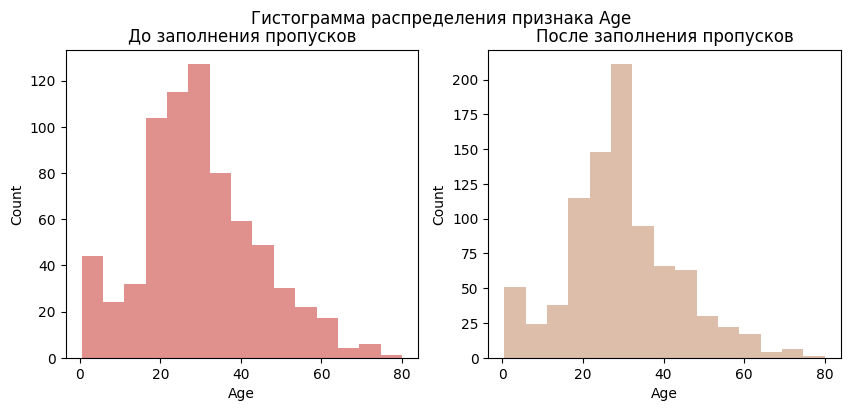

In [31]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
f.suptitle('Гистограмма распределения признака Age')

ax[0].hist(df_features['Age'], bins = 15, color = '#E0908D')
ax[0].set_title('До заполнения пропусков')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Count')

ax[1].hist(df_new['Age'], bins = 15, color = '#DDBEAA')
ax[1].set_title('После заполнения пропусков')
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Count')
plt.show()

In [32]:
df_features['Age'].median(), df_new['Age'].median()

(28.0, 29.0)

In [33]:
df_features['Age'].mean(), df_new['Age'].mean()

(np.float64(29.69911764705882), np.float64(29.352749719416384))

## Задания для самостоятельного выполнения
1. Сделайте копию датафрейма df и выведите информацию о нём.
2. Заполните пропуски в столбце Age, проделав аналогичные действия, но вместо модели линейной регрессии используйте модель KNeighborsRegressor.
3. Снова сделайте копию датафрейма df.
2. Произведите масштабирование данных, выполнив стандартную нормализацию. Представьте результат в виде датафрейма, добавив названия колонок.
2. Создайте объект класса KNNImputer с пятью соседями и однаковым весом для каждого из них (n_neighbors = 5, weights = 'uniform' стоят по умолчанию).
3. Заполните пропуски в столбце Age, обучив и трансформировав созданную модель на масштабированном датасете. Представьте результат в виде датафрейма, добавив названия колонок.
4. Верните данным исходный масштаб при помощи метода .inverse_transform(). Представьте результат в виде датафрейма, добавив названия колонок.
5. Округлите в получившемся датафрейме значение возраста до одного знака после запятой и выведите первые 10 строк этого датафрейма. Убедитесь, что пропусков в данных больше нет.
7. Постройте гистограмму распределения признака Age после заполнения пропусков. Выведите среднее и медианное значения для признака Age.
8. Сравните методы заполнения пропусков при помощи линейной регрессии и KNNImputer. Для этого обучите модель логистической регрессии на данных с заполненными пропусками первым и вторым методами, предварительно масштабировав их. Возьмите целевую переменную Survived из исходного файла. Выведите значение accuracy для каждого случая и сравните их значения между собой.

1. Сделайте копию датафрейма df и выведите информацию о нём.

In [59]:
df_copy = df.copy()
df_copy

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [60]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


2. Заполните пропуски в столбце Age, проделав аналогичные действия, но вместо модели линейной регрессии используйте модель KNeighborsRegressor.

In [36]:
df_copy_features = df_copy.drop('Survived', axis=1)
df_copy_features['Sex'] = df_copy_features['Sex'].map({'male': 1, 'female': 0})
df_copy_features = df_copy.select_dtypes(exclude=['object'])

In [37]:
scaler = StandardScaler()
scaler_copy_data = scaler.fit_transform(df_copy_features)
df_copy_scaled = pd.DataFrame(scaler_copy_data, columns = df_copy_features.columns)

In [38]:
Test_copy = df_copy_scaled[df_copy_scaled['Age'].isna()].copy()
Train_copy = df_copy_scaled.dropna()

In [39]:
y_train_copy = Train_copy['Age']
X_test_copy = Test_copy.drop('Age', axis=1)
X_train_copy = Train_copy.drop('Age', axis=1)

In [40]:
model_knn = KNeighborsRegressor()
model_knn.fit(X_train_copy, y_train_copy)
y_pred_copy = model_knn.predict(X_test_copy)

In [41]:
Test_copy['Age'] = y_pred_copy
Test_copy.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
5,-1.710669,-0.789272,0.827377,-0.516599,-0.474545,-0.473674,-0.478116
17,-1.664014,1.266990,-0.369365,0.103393,-0.474545,-0.473674,-0.386671
19,-1.656238,1.266990,0.827377,-0.406378,-0.474545,-0.473674,-0.502949
26,-1.629023,-0.789272,0.827377,-0.516599,-0.474545,-0.473674,-0.502949
28,-1.621247,1.266990,0.827377,-0.406378,-0.474545,-0.473674,-0.489776


3. Снова сделайте копию датафрейма df.

In [62]:
df_copy = df.copy()

4. Произведите масштабирование данных, выполнив стандартную нормализацию. Представьте результат в виде датафрейма, добавив названия колонок.

In [63]:
df_copy_features = df_copy.drop('Survived', axis=1)
df_copy_features['Sex'] = df_copy_features['Sex'].map({'male': 1, 'female': 0})
df_copy_features = df_copy.select_dtypes(exclude=['object'])

In [64]:
scaler = StandardScaler()
scaler_copy_data = scaler.fit_transform(df_copy_features)
df_copy_scaled = pd.DataFrame(scaler_copy_data, columns = df_copy_features.columns)
df_copy_scaled

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,-1.730108,-0.789272,0.827377,-0.530377,0.432793,-0.473674,-0.502445
1,-1.726220,1.266990,-1.566107,0.571831,0.432793,-0.473674,0.786845
2,-1.722332,1.266990,0.827377,-0.254825,-0.474545,-0.473674,-0.488854
3,-1.718444,1.266990,-1.566107,0.365167,0.432793,-0.473674,0.420730
4,-1.714556,-0.789272,0.827377,0.365167,-0.474545,-0.473674,-0.486337
...,...,...,...,...,...,...,...
886,1.714556,-0.789272,-0.369365,-0.185937,-0.474545,-0.473674,-0.386671
887,1.718444,1.266990,-1.566107,-0.737041,-0.474545,-0.473674,-0.044381
888,1.722332,-0.789272,0.827377,NaN,0.432793,2.008933,-0.176263
889,1.726220,1.266990,-1.566107,-0.254825,-0.474545,-0.473674,-0.044381


5. Создайте объект класса KNNImputer с пятью соседями и однаковым весом для каждого из них (n_neighbors = 5, weights = 'uniform' стоят по умолчанию).

In [43]:
imputer = KNNImputer(n_neighbors=5, weights='uniform')

6. Заполните пропуски в столбце Age, обучив и трансформировав созданную модель на масштабированном датасете. Представьте результат в виде датафрейма, добавив названия колонок.

In [44]:
X_train_imputer = imputer.fit_transform(X_train_copy)
X_test_imputer = imputer.transform(X_test_copy)

In [45]:
model.fit(X_train_imputer, y_train_copy)
y_pred_imputer = model.predict(X_test_imputer)

In [46]:
Test_copy['Age'] = y_pred_imputer
Test_copy.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
5,-1.710669,-0.789272,0.827377,-0.051562,-0.474545,-0.473674,-0.478116
17,-1.664014,1.266990,-0.369365,0.029780,-0.474545,-0.473674,-0.386671
19,-1.656238,1.266990,0.827377,-0.517345,-0.474545,-0.473674,-0.502949
26,-1.629023,-0.789272,0.827377,-0.049796,-0.474545,-0.473674,-0.502949
28,-1.621247,1.266990,0.827377,-0.517803,-0.474545,-0.473674,-0.489776


7. Верните данным исходный масштаб при помощи метода .inverse_transform(). Представьте результат в виде датафрейма, добавив названия колонок.

In [47]:
df_copy_new_scaled = pd.concat([Train_copy, Test_copy])
df_copy_new_scaled = df_copy_new_scaled.sort_index()
df_copy_new = pd.DataFrame(scaler.inverse_transform(df_copy_new_scaled), columns = df_copy_new_scaled.columns)
df_copy_new

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1.0,0.0,3.0,22.000000,1.0,0.0,7.2500
1,2.0,1.0,1.0,38.000000,1.0,0.0,71.2833
2,3.0,1.0,3.0,26.000000,0.0,0.0,7.9250
3,4.0,1.0,1.0,35.000000,1.0,0.0,53.1000
4,5.0,0.0,3.0,35.000000,0.0,0.0,8.0500
...,...,...,...,...,...,...,...
886,887.0,0.0,2.0,27.000000,0.0,0.0,13.0000
887,888.0,1.0,1.0,19.000000,0.0,0.0,30.0000
888,889.0,0.0,3.0,23.457198,1.0,2.0,23.4500
889,890.0,1.0,1.0,26.000000,0.0,0.0,30.0000


8. Округлите в получившемся датафрейме значение возраста до одного знака после запятой и выведите первые 10 строк этого датафрейма. Убедитесь, что пропусков в данных больше нет.

In [48]:
df_copy_new.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Age,0
SibSp,0
Parch,0
Fare,0


In [49]:
df_copy_new['Age'].sort_values().unique()

array([-5.38586765, -5.37861569, -5.37136374, -5.32888802, -5.16727309,
       -5.14862522, -5.14275459,  0.42      ,  0.67      ,  0.75      ,
        0.83      ,  0.92      ,  1.        ,  2.        ,  3.        ,
        4.        ,  5.        ,  6.        ,  7.        ,  8.        ,
        9.        , 10.        , 11.        , 12.        , 13.        ,
       14.        , 14.0750529 , 14.0850675 , 14.5       , 15.        ,
       16.        , 16.00299135, 16.02129389, 16.08345348, 16.10969864,
       17.        , 17.22060805, 17.30492767, 17.52732087, 17.98158192,
       18.        , 18.13717809, 18.1561713 , 18.18382802, 18.21283583,
       18.28428912, 19.        , 20.        , 20.5       , 20.55246577,
       20.79578719, 21.        , 21.66984012, 21.68676135, 22.        ,
       22.18252716, 22.18583537, 22.18917589, 22.19101533, 22.19498388,
       22.20254265, 22.21136235, 22.24316032, 22.26940548, 22.27838409,
       22.29648641, 22.29683174, 22.3018666 , 22.30928846, 22.32

In [50]:
df_copy_new['Age'] = df_copy_new['Age'].round(1)
df_copy_new['Age'] = df_copy_new['Age'].clip(lower=0.5)

In [51]:
df_copy_new['Age'].sort_values().unique()

array([ 0.5,  0.7,  0.8,  0.9,  1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  7. ,
        8. ,  9. , 10. , 11. , 12. , 13. , 14. , 14.1, 14.5, 15. , 16. ,
       16.1, 17. , 17.2, 17.3, 17.5, 18. , 18.1, 18.2, 18.3, 19. , 20. ,
       20.5, 20.6, 20.8, 21. , 21.7, 22. , 22.2, 22.3, 22.4, 22.5, 23. ,
       23.4, 23.5, 24. , 24.5, 24.9, 25. , 25.1, 26. , 27. , 27.3, 27.6,
       28. , 28.5, 28.9, 29. , 29.1, 29.2, 29.3, 30. , 30.1, 30.2, 30.3,
       30.5, 31. , 32. , 32.2, 32.5, 33. , 33.3, 33.7, 33.8, 34. , 34.5,
       35. , 36. , 36.5, 36.8, 36.9, 37. , 37.2, 37.3, 37.4, 37.8, 38. ,
       38.1, 38.2, 39. , 40. , 40.5, 41. , 41.9, 42. , 43. , 44. , 44.5,
       44.7, 44.8, 44.9, 45. , 45.4, 45.5, 46. , 47. , 48. , 49. , 50. ,
       51. , 52. , 53. , 54. , 55. , 55.5, 56. , 57. , 58. , 59. , 60. ,
       61. , 62. , 63. , 64. , 65. , 66. , 70. , 70.5, 71. , 74. , 80. ])

In [52]:
df_copy_new['Age'].sort_values()

,Age
846,0.5
803,0.5
792,0.5
159,0.5
324,0.5
...,...
116,70.5
96,71.0
493,71.0
851,74.0


9. Постройте гистограмму распределения признака Age после заполнения пропусков. Выведите среднее и медианное значения для признака Age.

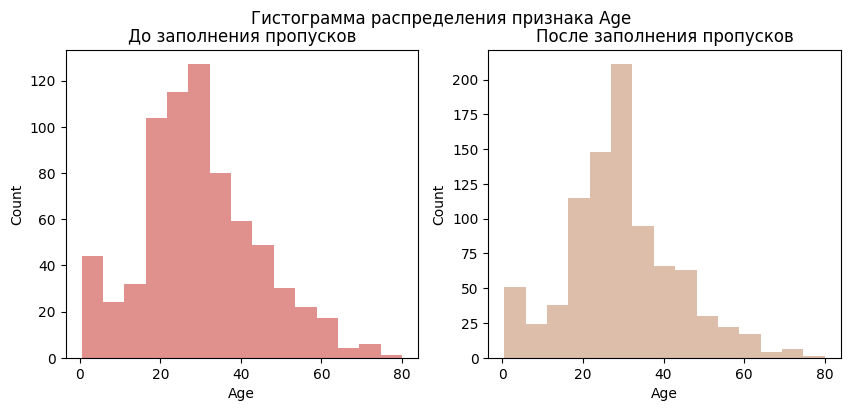

In [53]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
f.suptitle('Гистограмма распределения признака Age')

ax[0].hist(df_copy_features['Age'], bins = 15, color = '#E0908D')
ax[0].set_title('До заполнения пропусков')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Count')

ax[1].hist(df_copy_new['Age'], bins = 15, color = '#DDBEAA')
ax[1].set_title('После заполнения пропусков')
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Count')
plt.show()

In [54]:
df_copy_features['Age'].median(), df_copy_new['Age'].median()

(28.0, 29.0)

In [55]:
df_copy_features['Age'].mean(), df_copy_new['Age'].mean()

(np.float64(29.69911764705882), np.float64(29.352749719416384))

10. Сравните методы заполнения пропусков при помощи линейной регрессии и KNNImputer. Для этого обучите модель логистической регрессии на данных с заполненными пропусками первым и вторым методами, предварительно масштабировав их. Возьмите целевую переменную Survived из исходного файла. Выведите значение accuracy для каждого случая и сравните их значения между собой.

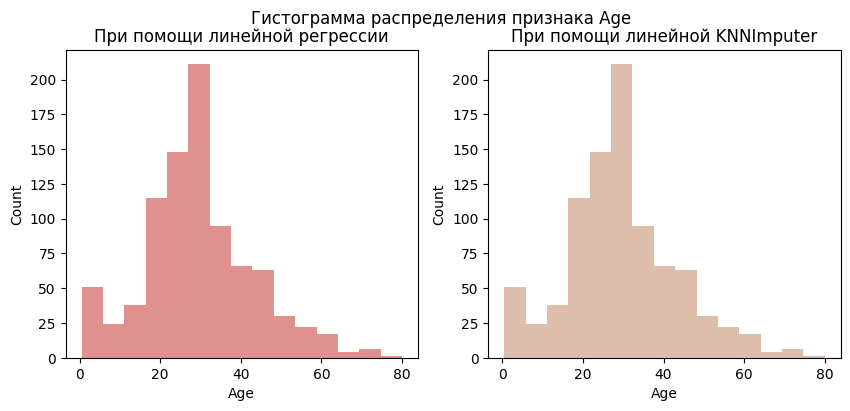

In [56]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
f.suptitle('Гистограмма распределения признака Age')

ax[0].hist(df_new['Age'], bins = 15, color = '#E0908D')
ax[0].set_title('При помощи линейной регрессии')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Count')

ax[1].hist(df_copy_new['Age'], bins = 15, color = '#DDBEAA')
ax[1].set_title('При помощи линейной KNNImputer')
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Count')
plt.show()

In [57]:
from sklearn.metrics import accuracy_score

In [58]:
accuracy_lr = accuracy_score(y_test, y_pred)
accuracy_lr

NameError: name 'y_test' is not defined

In [ ]:
accuracy_knn = accuracy_score(y_test_copy, y_pred_copy)
accuracy_knn